<a href="https://colab.research.google.com/github/ad9306/project4/blob/main/ai_07_%EC%A0%95%EC%97%98%EC%9C%A4project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project4**

ai가 단어만 적어도 문장으로 만들어 준다면 어떨까?
너무 재밌을 것 같지 않으십니까?

그렇기에 관련 자료를 찾아보았으나 너무 어려워서
문장을 요약하여 단어로 만드는 것을 첫 계단으로 밟아볼까 합니다

가설은 다음과 같습니다.

게임 설명을 요약하면 게임의 이름을 맞출 수 있을 것이다

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(seed=42)

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/19.%20Text%20Summarization/attention.py", filename="attention.py")
from attention import AttentionLayer

## 데이터 전처리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
game = pd.read_csv('/content/drive/MyDrive/CodeStates/appstore_games.csv')

In [ ]:
game

,URL,ID,Name,Subtitle,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
0,https://apps.apple.com/us/app/sudoku/id284921427,284921427,Sudoku,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,4.0,3553.0,2.99,NaN,"Join over 21,000,000 of our fans and download ...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",15853568.0,Games,"Games, Strategy, Puzzle",11/07/2008,30/05/2017
1,https://apps.apple.com/us/app/reversi/id284926400,284926400,Reversi,NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,3.5,284.0,1.99,NaN,"The classic game of Reversi, also known as Oth...",Kiss The Machine,4+,EN,12328960.0,Games,"Games, Strategy, Board",11/07/2008,17/05/2018
2,https://apps.apple.com/us/app/morocco/id284946595,284946595,Morocco,NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.0,8376.0,0.00,NaN,Play the classic strategy game Othello (also k...,Bayou Games,4+,EN,674816.0,Games,"Games, Board, Strategy",11/07/2008,5/09/2017
3,https://apps.apple.com/us/app/sudoku-free/id28...,285755462,Sudoku (Free),NaN,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,3.5,190394.0,0.00,NaN,"Top 100 free app for over a year.\nRated ""Best...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",21552128.0,Games,"Games, Strategy, Puzzle",23/07/2008,30/05/2017
4,https://apps.apple.com/us/app/senet-deluxe/id2...,285831220,Senet Deluxe,NaN,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,3.5,28.0,2.99,NaN,"""Senet Deluxe - The Ancient Game of Life and A...",RoGame Software,4+,"DA, NL, EN, FR, DE, EL, IT, JA, KO, NO, PT, RU...",34689024.0,Games,"Games, Strategy, Board, Education",18/07/2008,22/07/2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17002,https://apps.apple.com/us/app/stack-puzzle-ris...,1474626442,Stack Puzzle : Rise Tower,"Blast the cubes, solve puzzle!",https://is5-ssl.mzstatic.com/image/thumb/Purpl...,NaN,NaN,0.00,NaN,"The goal is very simple, move the square horiz...",Zhigang Pei,4+,EN,64795648.0,Games,"Games, Entertainment, Casual, Strategy",30/07/2019,30/07/2019
17003,https://apps.apple.com/us/app/eachother/id1474...,1474919257,EachOther,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,NaN,NaN,0.00,NaN,Collect a score while you play!!\n\nBy linking...,Sultan Shindi,4+,EN,110341120.0,Games,"Games, Family, Strategy",1/08/2019,1/08/2019
17004,https://apps.apple.com/us/app/rabbit-vs-tortoi...,1474962324,Rabbit Vs Tortoise,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,NaN,NaN,0.00,NaN,"""Rabbit Vs Tortoise is chess type cool simple ...",Vishal Baldha,4+,EN,23207936.0,Games,"Games, Strategy",3/08/2019,3/08/2019
17005,https://apps.apple.com/us/app/fatall/id1474963671,1474963671,FaTaLL,Most fun game!!!,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,NaN,NaN,0.00,"9.99, 49.99, 3.99",Upgrade your character and use your skills to ...,Tayrem Games,4+,EN,196750336.0,Games,"Games, Strategy, Action",1/08/2019,1/08/2019


In [ ]:
df_0= pd.DataFrame(game)
df_0.columns

Index(['URL', 'ID', 'Name', 'Subtitle', 'Icon URL', 'Average User Rating',
       'User Rating Count', 'Price', 'In-app Purchases', 'Description',
       'Developer', 'Age Rating', 'Languages', 'Size', 'Primary Genre',
       'Genres', 'Original Release Date', 'Current Version Release Date'],
      dtype='object')

In [ ]:
#데이터는 설명과 실제 게임 이름만 남기고 다 지워줍니다
df= df_0.drop(['URL', 'ID', 'Subtitle', 'Icon URL', 'Average User Rating', 'User Rating Count', 'Price', 'In-app Purchases', 'Developer', 'Age Rating', 'Languages', 'Size', 'Primary Genre', 'Genres', 'Original Release Date', 'Current Version Release Date'], axis=1)
df

,Name,Description
0,Sudoku,"Join over 21,000,000 of our fans and download ..."
1,Reversi,"The classic game of Reversi, also known as Oth..."
2,Morocco,Play the classic strategy game Othello (also k...
3,Sudoku (Free),"Top 100 free app for over a year.\nRated ""Best..."
4,Senet Deluxe,"""Senet Deluxe - The Ancient Game of Life and A..."
...,...,...
17002,Stack Puzzle : Rise Tower,"The goal is very simple, move the square horiz..."
17003,EachOther,Collect a score while you play!!\n\nBy linking...
17004,Rabbit Vs Tortoise,"""Rabbit Vs Tortoise is chess type cool simple ..."
17005,FaTaLL,Upgrade your character and use your skills to ...


In [ ]:
#결측치 확인
df.isnull().sum()

Name           0
Description    0
dtype: int64

In [ ]:
#중복값 제거
df.drop_duplicates(inplace=True)
df1=df.copy()

In [ ]:
# 대체할 용어들
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [ ]:
# NLTK의 불용어
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 179
{'during', 'each', 'ain', 'here', 'should', "aren't", 'before', "wouldn't", 'or', 'once', 'above', 'until', 'any', "isn't", 've', 'be', 'if', 'those', 'against', 'there', 'have', "won't", 'he', 'yourselves', 'between', 'weren', 'm', 'other', "you'll", "you'd", 'very', 'do', 'doesn', "you've", 'nor', 'by', 'am', 'under', 'again', 'won', 'ma', 'at', 'no', 'from', 'couldn', 'ours', 'ourselves', 'on', "she's", "didn't", "that'll", 'after', 'through', "weren't", 'herself', 'can', 'has', 'off', 'more', 'who', 'shan', 'does', 'up', 'haven', 'our', 'wasn', 'then', 'her', 'themselves', 'so', 'aren', 'which', 'into', 'both', 'o', 'd', 'they', 'me', 'just', 'needn', 's', 'while', "shan't", 'to', 'it', 'what', 'myself', 'himself', 'being', 're', 'their', 'these', 'because', 'hadn', 'yours', "hasn't", 'having', 'him', 'an', 'down', 'don', 'of', "should've", 'about', 'most', 'my', 'but', 'why', 'now', 'that', 'll', 'them', 'didn', 'some', 'y', 'only', "needn't", 'are', 'hasn', 'wouldn',

In [ ]:
#전처리 함수
def preprocessing(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z0-9]", " ", sentence) # 영어, 숫자 외 문자(특수문자 등) 공백으로 변환
    # 불용어 제거
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 5)
    return tokens

In [ ]:
pr_Des = []
for p in df['Description']:
    pr_Des.append(preprocessing(p))
pr_N = []
for p in df['Name']:
    pr_N.append(preprocessing(p, 0))

In [ ]:
df1['Description'] = pr_Des
df1['Name'] = pr_N
df1.head()

,Name,Description
0,sudoku,join 21 000 000 fans download one sudoku games...
1,reversi,classic game reversi also known othello much l...
2,morocco,play classic strategy game othello also known ...
3,sudoku,top 100 free app year nrated best sudoku game ...
4,deluxe,senet deluxe ancient game life afterlife nsene...


이름의 최소 길이 : 0
이름의 최대 길이 : 18
이름의 평균 길이 : 1.5021072000949725
설명의 최소 길이 : 1
설명의 최대 길이 : 1941
설명의 평균 길이 : 109.68807502819493


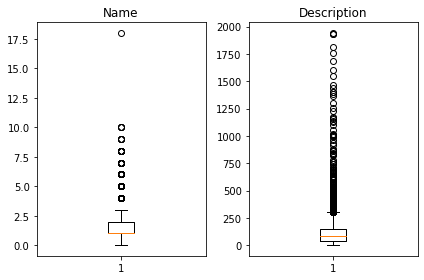

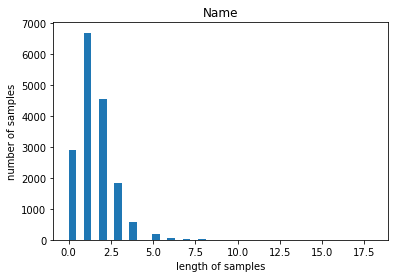

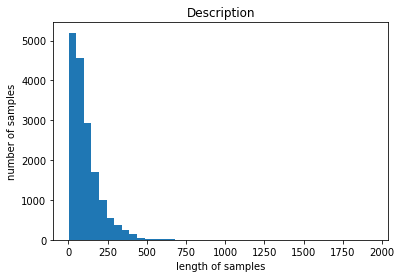

In [ ]:
#Name과 Description의 길이 분포 확인
Name_len = [len(s.split()) for s in df1['Name']]
Description_len = [len(s.split()) for s in df1['Description']]

print('이름의 최소 길이 : {}'.format(np.min(Name_len)))
print('이름의 최대 길이 : {}'.format(np.max(Name_len)))
print('이름의 평균 길이 : {}'.format(np.mean(Name_len)))
print('설명의 최소 길이 : {}'.format(np.min(Description_len)))
print('설명의 최대 길이 : {}'.format(np.max(Description_len)))
print('설명의 평균 길이 : {}'.format(np.mean(Description_len)))


plt.subplot(1,2,1)
plt.boxplot(Name_len)
plt.title('Name')
plt.subplot(1,2,2)
plt.boxplot(Description_len)
plt.title('Description')
plt.tight_layout()
plt.show()

plt.title('Name')
plt.hist(Name_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Description')
plt.hist(Description_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
#Name에 결측치가 있으니 찾아줍니다
df1.isnull().sum()

Name           0
Description    0
dtype: int64

In [ ]:
#나타나지 않는 것 보니 빈 셀입니다 찾아서 제거해줍니다
df1['Name'].replace('', np.nan, inplace=True)
df1.isnull().sum()

Name           2906
Description       0
dtype: int64

In [ ]:
df1=df1.dropna(0)
df1.isnull().sum()

Name           0
Description    0
dtype: int64

In [ ]:
df1

,Name,Description
0,sudoku,join 21 000 000 fans download one sudoku games...
1,reversi,classic game reversi also known othello much l...
2,morocco,play classic strategy game othello also known ...
3,sudoku,top 100 free app year nrated best sudoku game ...
4,deluxe,senet deluxe ancient game life afterlife nsene...
...,...,...
17002,puzzle,goal simple move square horizontally fill clea...
17003,eachother,collect score play nby linking characters type...
17004,rabbit tortoise,rabbit vs tortoise chess type cool simple game...
17005,fatall,upgrade character use skills prevent birds rea...


In [ ]:
#평균 길이보다 과하게 긴 설명이나 이름을 제거해 줍니다
des_maxlen = 218
name_maxlen = 3
def check_len(maxlen, list):
  count = 0
  for s in list:
    if(len(s.split()) <= maxlen):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(maxlen, (count / len(list))))

check_len(des_maxlen, df1['Description'])
check_len(name_maxlen, df1['Name'])

전체 샘플 중 길이가 218 이하인 샘플의 비율: 0.882648303565024
전체 샘플 중 길이가 3 이하인 샘플의 비율: 0.9363029911771035


In [ ]:
df1 = df1[df1['Description'].apply(lambda x: len(x.split()) <= des_maxlen)]
df1 = df1[df1['Name'].apply(lambda x: len(x.split()) <= name_maxlen)]
df1

,Name,Description
0,sudoku,join 21 000 000 fans download one sudoku games...
1,reversi,classic game reversi also known othello much l...
2,morocco,play classic strategy game othello also known ...
3,sudoku,top 100 free app year nrated best sudoku game ...
4,deluxe,senet deluxe ancient game life afterlife nsene...
...,...,...
17002,puzzle,goal simple move square horizontally fill clea...
17003,eachother,collect score play nby linking characters type...
17004,rabbit tortoise,rabbit vs tortoise chess type cool simple game...
17005,fatall,upgrade character use skills prevent birds rea...


In [ ]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가합니다
df1['dc_input'] = df1['Name'].apply(lambda x : 'sostoken '+ x)
df1['dc_target'] = df1['Name'].apply(lambda x : x + ' eostoken')
df1.head()

,Name,Description,dc_input,dc_target
0,sudoku,join 21 000 000 fans download one sudoku games...,sostoken sudoku,sudoku eostoken
1,reversi,classic game reversi also known othello much l...,sostoken reversi,reversi eostoken
2,morocco,play classic strategy game othello also known ...,sostoken morocco,morocco eostoken
3,sudoku,top 100 free app year nrated best sudoku game ...,sostoken sudoku,sudoku eostoken
4,deluxe,senet deluxe ancient game life afterlife nsene...,sostoken deluxe,deluxe eostoken


In [ ]:
ec_input = np.array(df1['Description'])
dc_input = np.array(df1['dc_input'])
dc_target = np.array(df1['dc_target'])

##딥러닝 방식 적용

In [ ]:
#8:2로 데이터 분리 정수 시퀀스를 만들어서 함께 분리해준다.
indices = np.arange(ec_input.shape[0])
np.random.shuffle(indices)

ec_input = ec_input[indices]
dc_input = dc_input[indices]
dc_target = dc_target[indices]

#train, test= train_test_split(ec_input, test_size=0.2, shuffle=True, random_state=42) 으로 될 줄 알았는데 안된다.
#어떻게 쓸 수 있을지 고민해보자

In [ ]:
num = int(len(ec_input)*0.2) #그냥 ec의 20퍼를 구해서 나눠준다.

ec_in_train = ec_input[:-num]
dc_in_train = dc_input[:-num]
dc_tar_train = dc_target[:-num]

ec_in_test = ec_input[-num:]
dc_in_test = dc_input[-num:]
dc_tar_test = dc_target[-num:]

In [ ]:
#인코딩
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(ec_in_train)

In [ ]:
#텍스트를 정수로 변환
ec_in_train = src_tokenizer.texts_to_sequences(ec_in_train) 
ec_in_test = src_tokenizer.texts_to_sequences(ec_in_test)

In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(dc_in_train)
tar_tokenizer.fit_on_texts(dc_tar_train)

In [ ]:
dc_in_train = tar_tokenizer.texts_to_sequences(dc_in_train) 
dc_tar_train = tar_tokenizer.texts_to_sequences(dc_tar_train)
dc_in_test = tar_tokenizer.texts_to_sequences(dc_in_test)
dc_tar_test = tar_tokenizer.texts_to_sequences(dc_tar_test)

In [ ]:
#패딩하기
ec_in_train = pad_sequences(ec_in_train, maxlen = des_maxlen, padding='post')
ec_in_test = pad_sequences(ec_in_test, maxlen = des_maxlen, padding='post')
dc_in_train = pad_sequences(dc_in_train, maxlen = name_maxlen, padding='post')
dc_tar_train = pad_sequences(dc_tar_train, maxlen = name_maxlen, padding='post')
dc_in_test = pad_sequences(dc_in_test, maxlen = name_maxlen, padding='post')
dc_tar_test = pad_sequences(dc_tar_test, maxlen = name_maxlen, padding='post')

###모델설계


In [ ]:
#단어 길이가 매우 길어 seq2seq + attention을 사용해 보기로 했습니다
embedding_dim = 128
hidden_size = 256
src_vocab = 9000
tar_vocab = 900

# 인코더
ec_inputs = Input(shape=(des_maxlen,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(ec_inputs)

# 인코더의 LSTM 1
ec_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
ec_output1, state_h1, state_c1 = ec_lstm1(enc_emb)

# 인코더의 LSTM 2
ec_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
ec_output2, state_h2, state_c2 = ec_lstm2(ec_output1)

# 인코더의 LSTM 3
ec_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
ec_outputs, state_h, state_c= ec_lstm3(ec_output2)

In [ ]:
# 디코더
dc_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(dc_inputs)

# 디코더의 LSTM
dc_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
dc_outputs, _, _ = dc_lstm(dec_emb, initial_state = [state_h, state_c])#디코더의 초기 상태는 인코터의 상태로 해줘야 합니다


In [ ]:
# 디코더의 출력층
dc_softmax_layer = Dense(tar_vocab, activation = 'softmax')
dc_softmax_outputs = dc_softmax_layer(dc_outputs) 

# 모델 정의
model = Model([ec_inputs, dc_inputs], dc_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 218)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 218, 128)     1152000     ['input_3[0][0]']                
                                                                                                  
 lstm_4 (LSTM)                  [(None, 218, 256),   394240      ['embedding_2[0][0]']            
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In [ ]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([ec_outputs, dc_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
dc_concat_input = Concatenate(axis = -1, name='concat_layer')([dc_outputs, attn_out])

# 디코더의 출력층
dc_softmax_layer = Dense(tar_vocab, activation='softmax')
dc_softmax_outputs = dc_softmax_layer(dc_concat_input)

# 모델 정의
model = Model([ec_inputs, dc_inputs], dc_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 218)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 218, 128)     1152000     ['input_3[0][0]']                
                                                                                                  
 lstm_4 (LSTM)                  [(None, 218, 256),   394240      ['embedding_2[0][0]']            
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In [ ]:
#모델 컴파일 후 학습
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [ec_in_train, dc_in_train], y = dc_tar_train,
          validation_data = ([ec_in_test, dc_in_test], dc_tar_test),
          batch_size = 256, callbacks=[early], epochs = 50)

Epoch 1/50
36/36 [==============================] - 150s 4s/step - loss: nan - val_loss: nan
Epoch 2/50
36/36 [==============================] - 135s 4s/step - loss: nan - val_loss: nan
Epoch 00002: early stopping


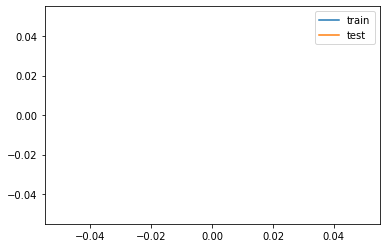

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
